In [2]:
import pandas as pd
import numpy as np
import datetime
from sklearn.impute import KNNImputer
import statsmodels.api as sm

from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import random
from scalecast.Forecaster import Forecaster
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import TimeSeriesSplit
from tqdm.notebook import tqdm as log_progress
from scalecast import GridGenerator
from scalecast.SeriesTransformer import SeriesTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

/Users/justinfarnan_hakkoda/capstone_project/Capstone_Project/.venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
## import the cleaned dataset
file_path = "/Users/justinfarnan_hakkoda/capstone_project/Capstone_Project/Cleaned_Data/cleaned_crypto_updated_module5.csv"
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,time,product_id,low,close,volume,volatility,pct_change,day_of_week,day_name,...,volatility_7d,volatility_14d,volatility_30d,momentum_1d,momentum_7d,momentum_30d,RSI_14,pct_change_lag_1,pct_change_lag_3,pct_change_lag_7
0,0,2021-07-16,ADA-USD,1.16610,1.17140,3.676491e+07,6.783295,0.001366,3,Thursday,...,0.145345,0.143173,0.260852,0.001366,0.031159,0.851289,70.002537,0.001366,0.001366,0.001366
1,1,2021-07-16,COMP-USD,367.10000,367.89000,2.381554e+04,11.822392,0.030036,3,Thursday,...,0.171204,0.181250,0.286050,0.030036,0.136318,0.329202,58.238869,0.030036,0.030036,0.030036
2,2,2021-07-16,ETH-USD,1850.15000,1877.22000,1.842217e+05,6.226522,0.012002,3,Thursday,...,0.136244,0.136448,0.220291,0.012002,0.132425,0.763741,88.586851,0.012002,0.012002,0.012002
3,3,2021-07-16,LINK-USD,15.13583,15.23963,2.246281e+06,7.919420,0.007881,3,Thursday,...,0.159056,0.224341,0.282708,0.007881,0.083315,0.832218,78.511587,0.007881,0.007881,0.007881
4,4,2021-07-16,LTC-USD,120.44000,120.68000,1.305546e+05,6.127532,-0.005469,3,Thursday,...,0.137388,0.139710,0.222501,-0.005469,0.029831,0.530991,78.981735,-0.005469,-0.005469,-0.005469


In [4]:
# remove the unamed column and the day_of_week column
df = df.drop(columns = ['Unnamed: 0', 'day_name'])
df.head()

,time,product_id,low,close,volume,volatility,pct_change,day_of_week,volume_lag_1,volume_lag_3,...,volatility_7d,volatility_14d,volatility_30d,momentum_1d,momentum_7d,momentum_30d,RSI_14,pct_change_lag_1,pct_change_lag_3,pct_change_lag_7
0,2021-07-16,ADA-USD,1.16610,1.17140,3.676491e+07,6.783295,0.001366,3,3.676491e+07,3.676491e+07,...,0.145345,0.143173,0.260852,0.001366,0.031159,0.851289,70.002537,0.001366,0.001366,0.001366
1,2021-07-16,COMP-USD,367.10000,367.89000,2.381554e+04,11.822392,0.030036,3,2.381554e+04,2.381554e+04,...,0.171204,0.181250,0.286050,0.030036,0.136318,0.329202,58.238869,0.030036,0.030036,0.030036
2,2021-07-16,ETH-USD,1850.15000,1877.22000,1.842217e+05,6.226522,0.012002,3,1.842217e+05,1.842217e+05,...,0.136244,0.136448,0.220291,0.012002,0.132425,0.763741,88.586851,0.012002,0.012002,0.012002
3,2021-07-16,LINK-USD,15.13583,15.23963,2.246281e+06,7.919420,0.007881,3,2.246281e+06,2.246281e+06,...,0.159056,0.224341,0.282708,0.007881,0.083315,0.832218,78.511587,0.007881,0.007881,0.007881
4,2021-07-16,LTC-USD,120.44000,120.68000,1.305546e+05,6.127532,-0.005469,3,1.305546e+05,1.305546e+05,...,0.137388,0.139710,0.222501,-0.005469,0.029831,0.530991,78.981735,-0.005469,-0.005469,-0.005469


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10764 entries, 0 to 10763
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              10764 non-null  object 
 1   product_id        10764 non-null  object 
 2   low               10764 non-null  float64
 3   close             10764 non-null  float64
 4   volume            10764 non-null  float64
 5   volatility        10764 non-null  float64
 6   pct_change        10764 non-null  float64
 7   day_of_week       10764 non-null  int64  
 8   volume_lag_1      10764 non-null  float64
 9   volume_lag_3      10764 non-null  float64
 10  volume_lag_7      10764 non-null  float64
 11  RSI               10764 non-null  float64
 12  MACD              10764 non-null  float64
 13  Signal_Line       10764 non-null  float64
 14  volatility_7d     10764 non-null  float64
 15  volatility_14d    10764 non-null  float64
 16  volatility_30d    10764 non-null  float6

In [6]:
# set the time column as the index then scale the float values
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
# scaler = StandardScaler()
# for columns in df.columns:
#     if df[columns].dtype == 'float':
#         df[[columns]] = scaler.fit_transform(df[[columns]])
df.head()


,product_id,low,close,volume,volatility,pct_change,day_of_week,volume_lag_1,volume_lag_3,volume_lag_7,...,volatility_7d,volatility_14d,volatility_30d,momentum_1d,momentum_7d,momentum_30d,RSI_14,pct_change_lag_1,pct_change_lag_3,pct_change_lag_7
time,,,,,,,,,,,,,,,,,,,,,
2021-07-16,ADA-USD,1.16610,1.17140,3.676491e+07,6.783295,0.001366,3,3.676491e+07,3.676491e+07,3.676491e+07,...,0.145345,0.143173,0.260852,0.001366,0.031159,0.851289,70.002537,0.001366,0.001366,0.001366
2021-07-16,COMP-USD,367.10000,367.89000,2.381554e+04,11.822392,0.030036,3,2.381554e+04,2.381554e+04,2.381554e+04,...,0.171204,0.181250,0.286050,0.030036,0.136318,0.329202,58.238869,0.030036,0.030036,0.030036
2021-07-16,ETH-USD,1850.15000,1877.22000,1.842217e+05,6.226522,0.012002,3,1.842217e+05,1.842217e+05,1.842217e+05,...,0.136244,0.136448,0.220291,0.012002,0.132425,0.763741,88.586851,0.012002,0.012002,0.012002
2021-07-16,LINK-USD,15.13583,15.23963,2.246281e+06,7.919420,0.007881,3,2.246281e+06,2.246281e+06,2.246281e+06,...,0.159056,0.224341,0.282708,0.007881,0.083315,0.832218,78.511587,0.007881,0.007881,0.007881
2021-07-16,LTC-USD,120.44000,120.68000,1.305546e+05,6.127532,-0.005469,3,1.305546e+05,1.305546e+05,1.305546e+05,...,0.137388,0.139710,0.222501,-0.005469,0.029831,0.530991,78.981735,-0.005469,-0.005469,-0.005469


In [6]:
df.columns

Index(['product_id', 'low', 'close', 'volume', 'volatility', 'pct_change',
       'day_of_week', 'volume_lag_1', 'volume_lag_3', 'volume_lag_7', 'RSI',
       'MACD', 'Signal_Line', 'volatility_7d', 'volatility_14d',
       'volatility_30d', 'momentum_1d', 'momentum_7d', 'momentum_30d',
       'RSI_14', 'pct_change_lag_1', 'pct_change_lag_3', 'pct_change_lag_7'],
      dtype='object')

In [7]:
def plot_test_export_summaries(f):
    """ exports the relevant statisitcal information and displays a plot of the test-set results for the last model run
    """
    f.plot_test_set(models=f.estimator,ci=True)
    plt.title(f'{f.estimator} test-set results',size=16)
    plt.show()
    return f.export('model_summaries',determine_best_by='TestSetMAPE')[
        [
            'ModelNickname',
            'HyperParams',
            'TestSetMAPE',
            'TestSetR2',
            'InSampleMAPE',
            'InSampleR2'
        ]
    ]

In [ ]:
# 'day_of_week', 'volume_lag_1', 'volume_lag_3', 'volume_lag_7',
    # 'RSI', 'MACD', 'volatility_7d', 'volatility_30d', 'momentum_7d',  'pct_change_lag_1', 'pct_change_lag_3', 'pct_change_lag_7'

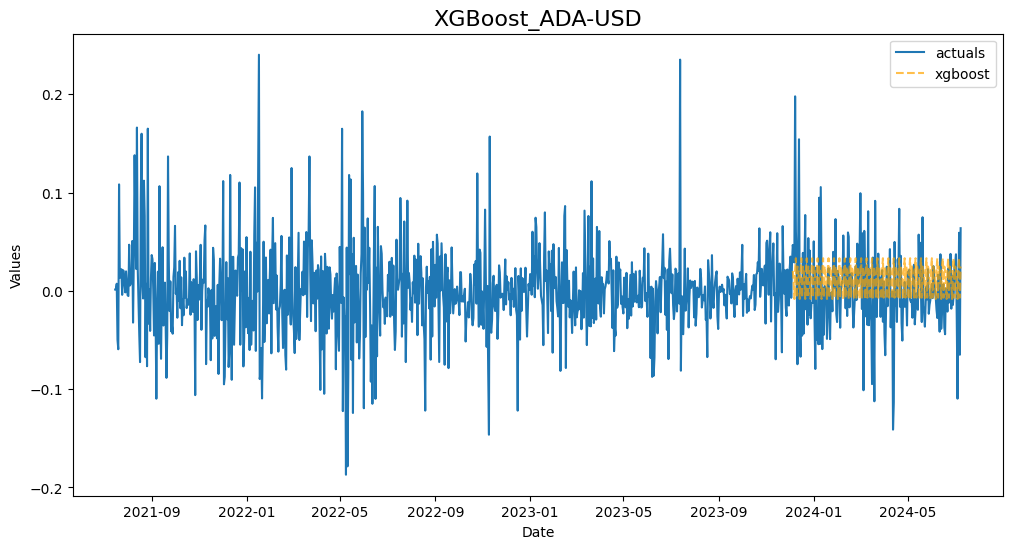

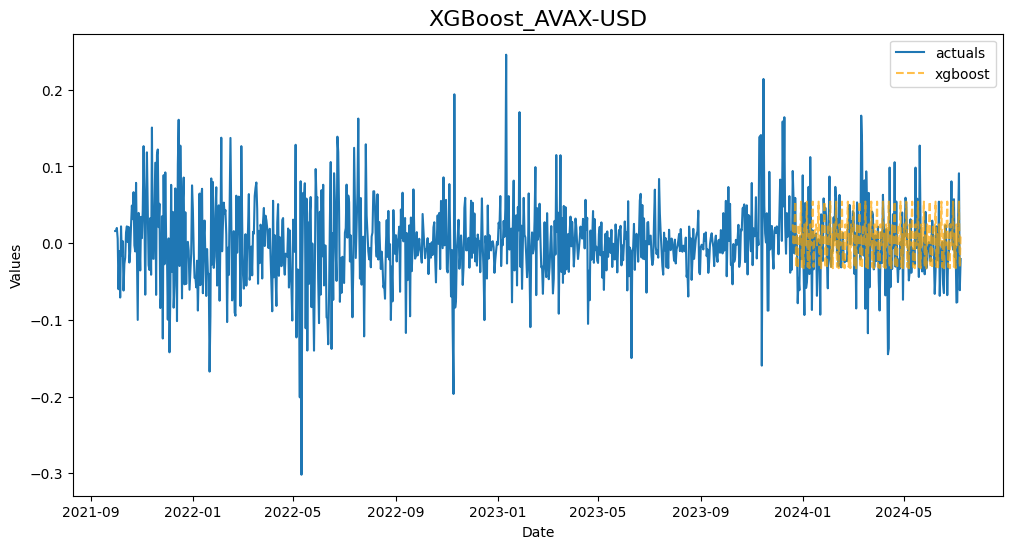

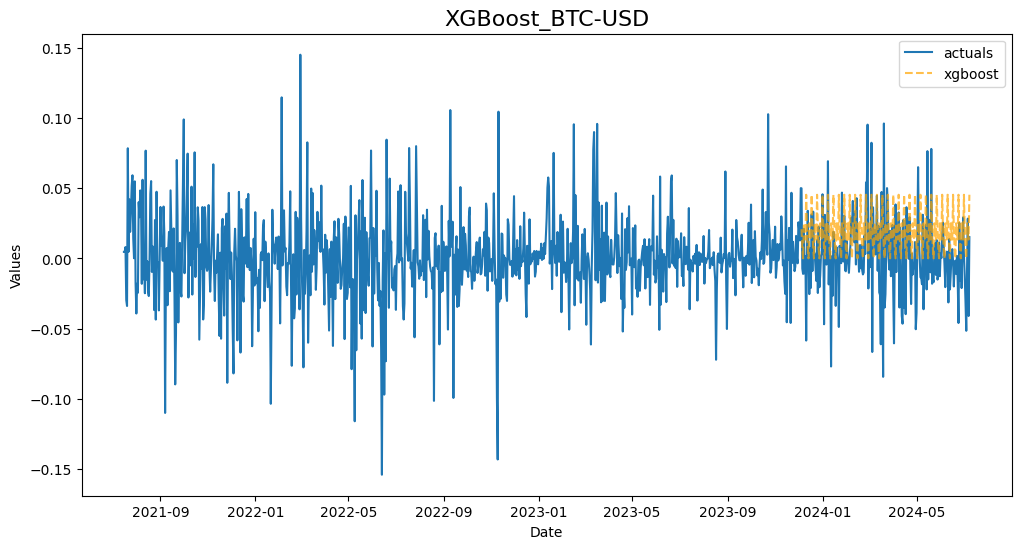

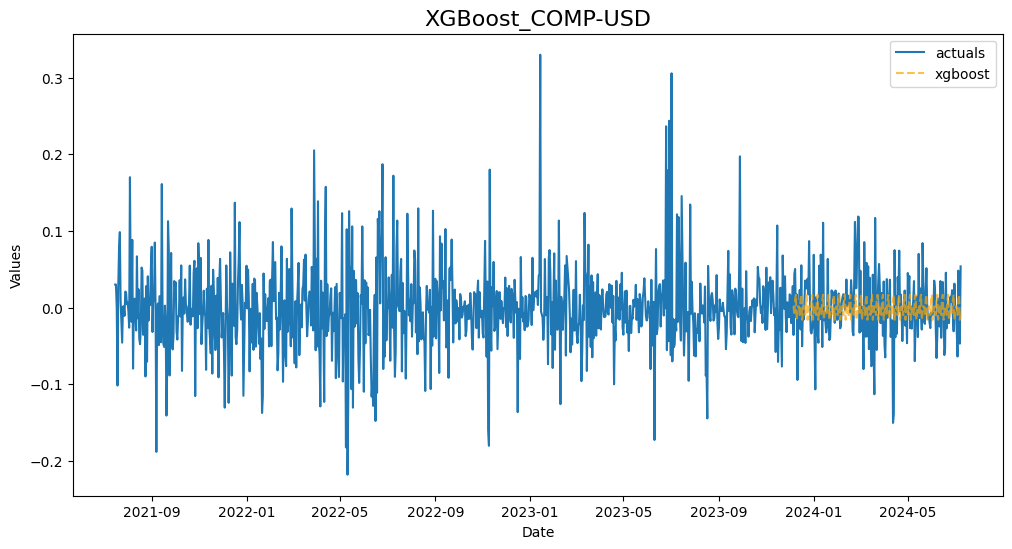

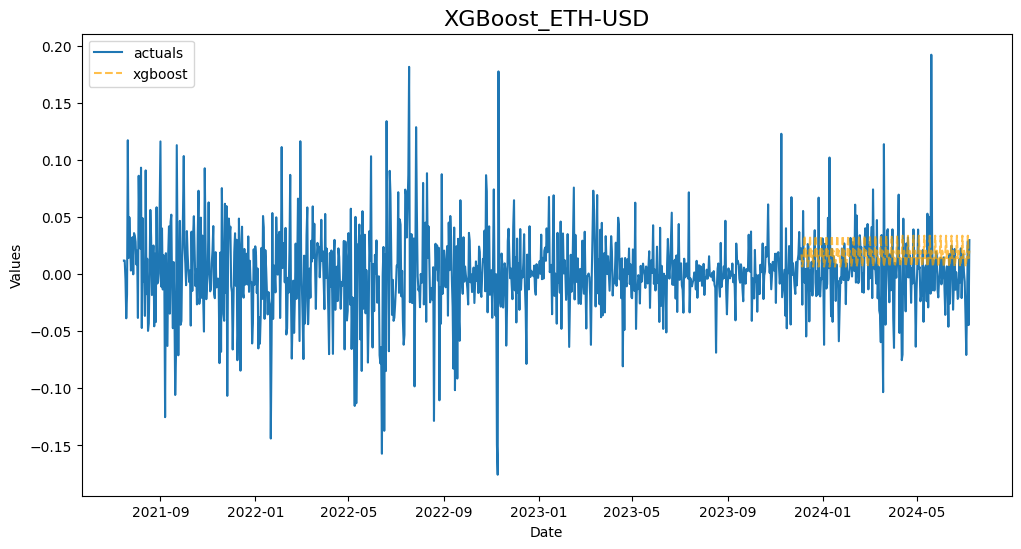

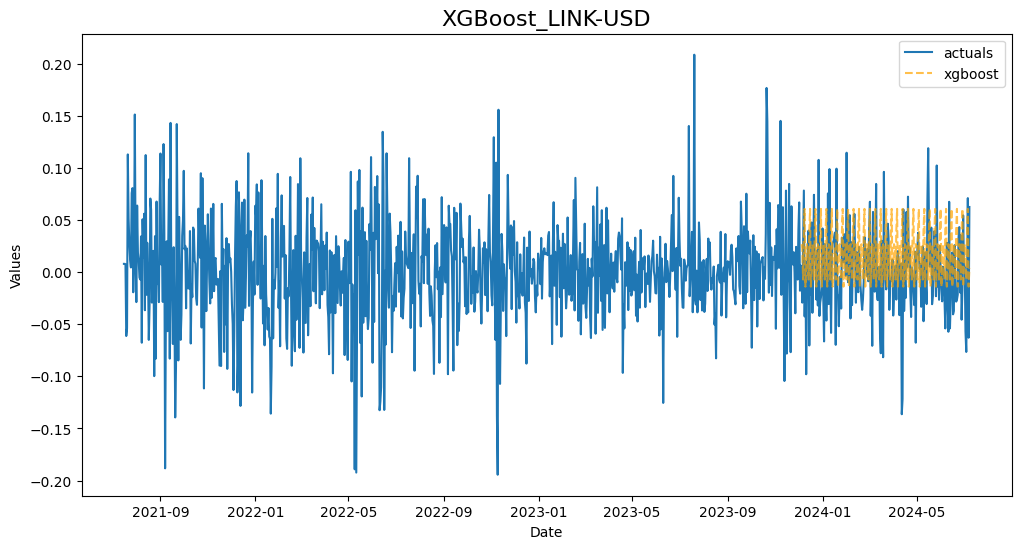

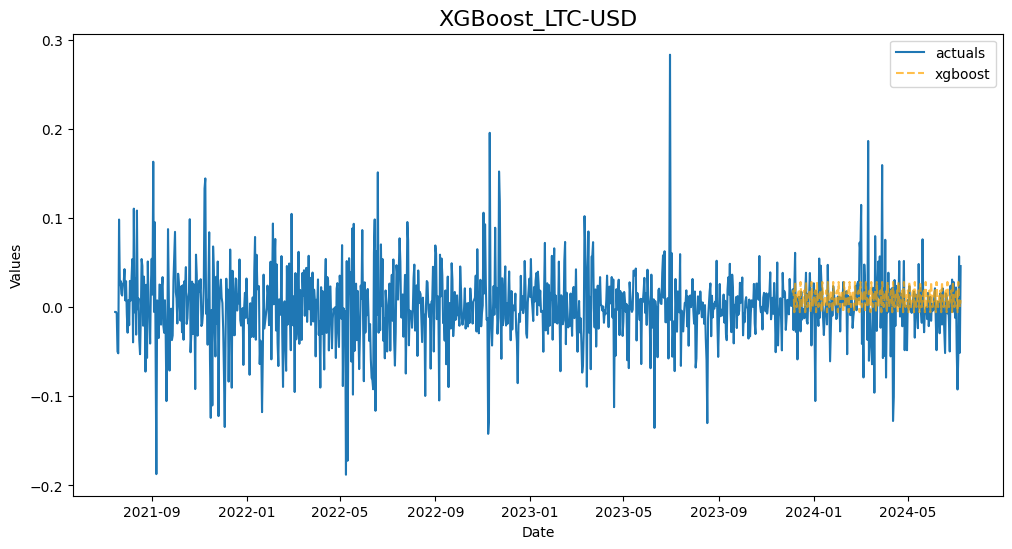

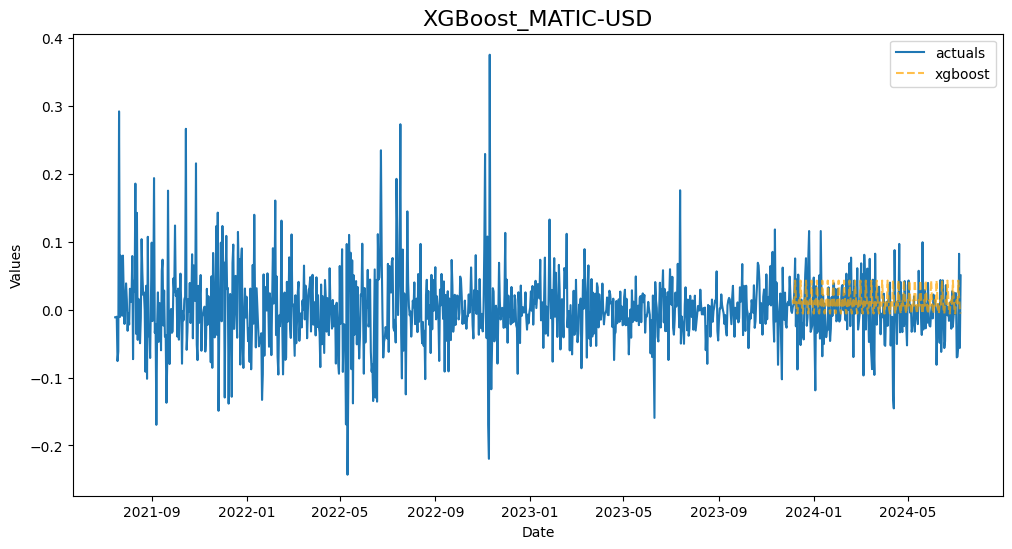

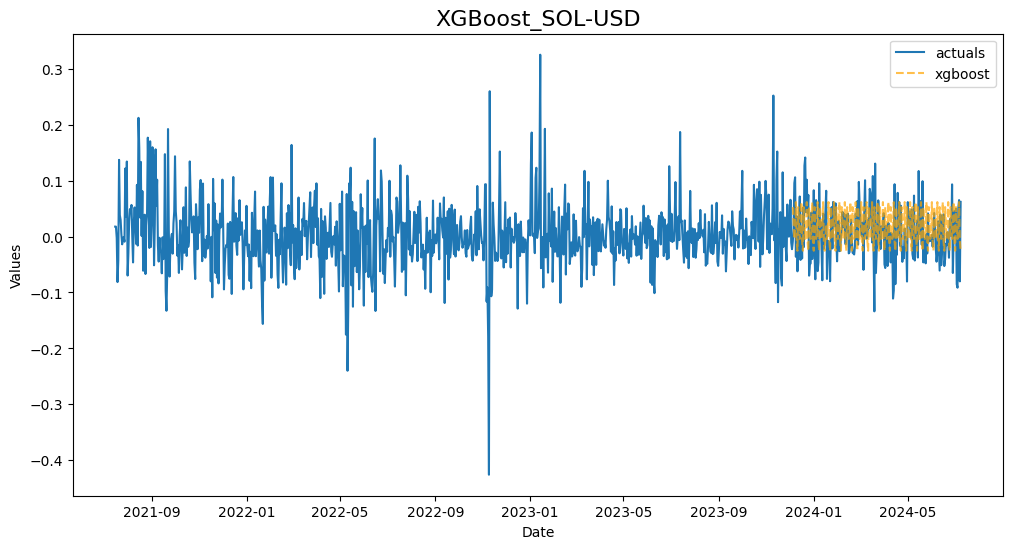

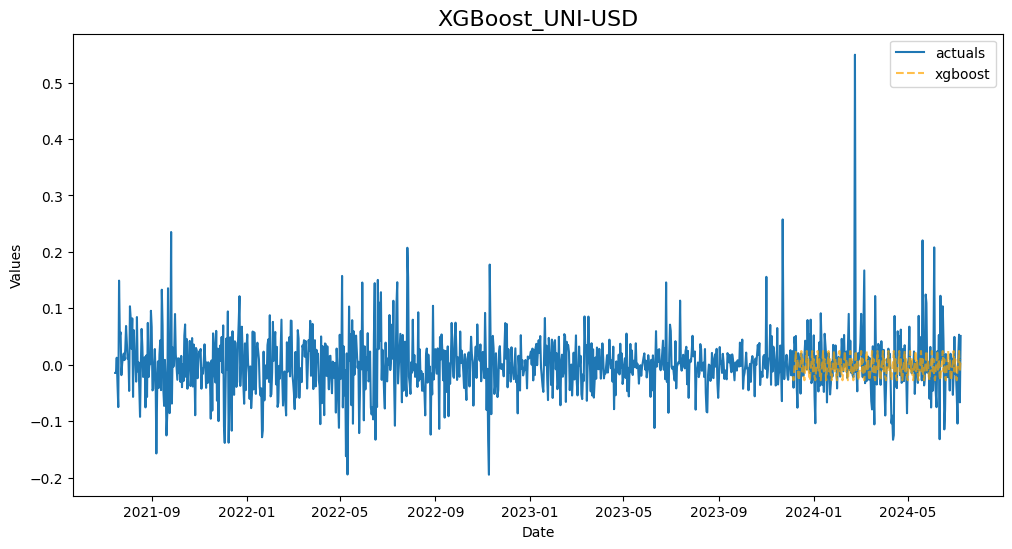

In [7]:
x_columns = [
    'volume', 'volatility'
]
results_dict = {}
for product_id, group in df.groupby('product_id'):
    # Create a separate model for each product ID
    #future_dates = pd.date_range(start='2024-07-12', periods=7).strftime('%Y-%m-%d').tolist()
    f = Forecaster(
        y=group['pct_change'],  # Target variable
        X=group[x_columns],  # Exogenous variables
        current_dates=group.index.strftime('%Y-%m-%d').tolist(),  # Date index
        future_dates=None,
        test_length=0,
        validation_length=None,
        cis=False,
        
    )
    f.set_test_length(.2)
    f.set_last_future_date('2024-07-18') 
    #f.add_ar_terms(6)
    f.add_seasonal_regressors('day_of_week', dummy=True)  # Use day of week as a seasonal regressor
    f.add_time_trend()
    f.set_estimator('xgboost')  # Use XGBoost instead of LSTM
    
    # Fit the model
    f.manual_forecast()
    f.set_metrics(['mape', 'mse', 'rmse', 'mae'])
    f.export(
      to_excel = True,
      determine_best_by = 'TestSetMAPE',
      excel_name = f'forecast_metrics/XGBoost_Model_{product_id}.xlsx'
  )
    # Evaluate the model
    f.plot_test_set(order_by='TestSetMAPE', models=['xgboost'], ci=True)
    # plot_test_export_summaries(f)
    plt.title(f'XGBoost_{product_id}', size=16)
    plt.show()
    
    # # Store the results in the dictionary
    # results_dict[product_id] = {
    #     'forecast': f.generate_future_dates(7),
    #     'evaluation': f.get_metrics(),
    #     'models': f.models
    # }

In [8]:
# Specify the Excel file path
file_path = '/Users/justinfarnan_hakkoda/capstone_project/Capstone_Project/forecast_metrics/XGBoost_Model_ADA-USD.xlsx'

# Get the list of sheet names
sheet_names = pd.ExcelFile(file_path).sheet_names

# Create a dictionary to store the data for each sheet
data_dict = {}

# Loop through each sheet and read in the data
for sheet_name in sheet_names:
    ada_metircs = pd.read_excel(file_path, sheet_name=sheet_name)
    data_dict[sheet_name] = ada_metircs

# Now you can access the data for each sheet using the sheet name as the key
for sheet_name, ada_metircs in data_dict.items():
    print(f"Sheet Name: {sheet_name}")




Sheet Name: model_summaries
Sheet Name: lvl_fcsts
Sheet Name: lvl_test_set_predictions


In [9]:
model_sums = pd.read_excel(file_path, sheet_name='lvl_test_set_predictions')
model_sums

,DATE,actual,xgboost
0,2023-12-05,0.046706,0.020300
1,2023-12-06,0.040160,0.010606
2,2023-12-07,0.028900,-0.008234
3,2023-12-08,0.197937,0.021898
4,2023-12-09,0.061000,0.033201
...,...,...,...
211,2024-07-04,-0.109690,-0.008234
212,2024-07-05,-0.033149,0.021898
213,2024-07-06,0.059143,0.033201
214,2024-07-07,-0.065012,-0.006910


In [10]:
ada_forecasts = pd.read_excel(file_path, sheet_name='lvl_fcsts')
ada_forecasts

,DATE,xgboost
0,2024-07-09,-0.009480
1,2024-07-10,-0.028760
2,2024-07-11,-0.095350
3,2024-07-12,-0.032236
4,2024-07-13,0.049597
5,2024-07-14,-0.060059
6,2024-07-15,0.056012
7,2024-07-16,-0.009480
8,2024-07-17,-0.028760
9,2024-07-18,-0.095350


In [12]:
ada_metrics = pd.read_excel(file_path, sheet_name='model_summaries')
ada_metrics['Xvars']

0    ['day_of_week', 'day_of_week_0', 'day_of_week_...
Name: Xvars, dtype: object

In [14]:
test_df = pd.read_csv('/Users/justinfarnan_hakkoda/capstone_project/Capstone_Project/RAW_Data/test_weekago_updt_717.csv')
test_df['pct_change'] = test_df.groupby('product_id')['close'].pct_change()

In [15]:
test_df.sort_values('time', inplace = True)

In [16]:
test_df = test_df.rename(columns = {'time': 'DATE'})

In [17]:
test_df['DATE'] = pd.to_datetime(test_df['DATE'])

In [18]:
ada_test = test_df[test_df['product_id'] == 'ADA-USD']
ada_test

,Unnamed: 0,DATE,low,high,open,close,volume,price_change,average_price,volatility,product_id,pct_change
27,27,2024-07-12,0.3932,0.4180,0.3962,0.4164,1.924438e+07,0.0202,0.40560,6.307223,ADA-USD,-0.057705
26,26,2024-07-13,0.4117,0.4471,0.4166,0.4419,2.012002e+07,0.0253,0.42940,8.598494,ADA-USD,0.023390
25,25,2024-07-14,0.4239,0.4453,0.4419,0.4318,1.315974e+07,-0.0101,0.43460,5.048360,ADA-USD,-0.029881
24,24,2024-07-15,0.4312,0.4460,0.4318,0.4451,1.997885e+07,0.0133,0.43860,3.432282,ADA-USD,0.015746
23,23,2024-07-16,0.4266,0.4528,0.4452,0.4382,2.000276e+07,-0.0070,0.43970,6.141585,ADA-USD,0.004815
22,22,2024-07-17,0.4355,0.4568,0.4381,0.4361,1.876214e+07,-0.0020,0.44615,4.890930,ADA-USD,-0.006153
21,21,2024-07-18,0.4359,0.4434,0.4360,0.4388,1.064133e+06,0.0028,0.43965,1.720578,ADA-USD,NaN


In [19]:
print(ada_forecasts.columns)
print(ada_test.columns)

Index(['DATE', 'xgboost'], dtype='object')
Index(['Unnamed: 0', 'DATE', 'low', 'high', 'open', 'close', 'volume',
       'price_change', 'average_price', 'volatility', 'product_id',
       'pct_change'],
      dtype='object')


In [20]:
combine_df = pd.merge(ada_forecasts, ada_test[['product_id', 'pct_change', 'DATE']], on='DATE', how='inner')

In [21]:
combine_df.dropna(inplace = True)

In [22]:
combine_df

,DATE,xgboost,product_id,pct_change
0,2024-07-12,0.005271,ADA-USD,-0.057705
1,2024-07-13,0.001796,ADA-USD,0.023390
2,2024-07-14,-0.032963,ADA-USD,-0.029881
3,2024-07-15,0.033117,ADA-USD,0.015746
4,2024-07-16,-0.000132,ADA-USD,0.004815
5,2024-07-17,-0.023033,ADA-USD,-0.006153


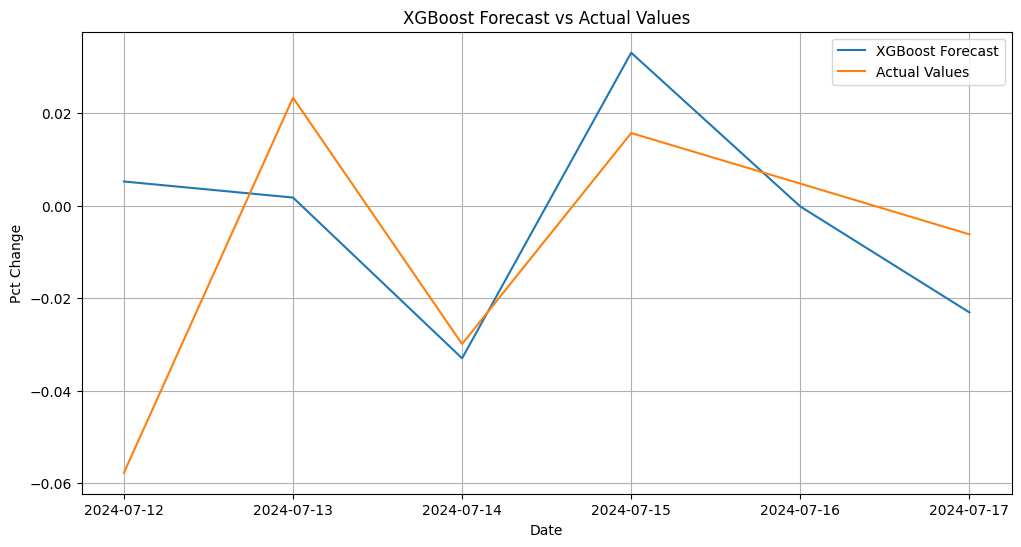

In [23]:
import matplotlib.pyplot as plt

# Assuming combine_df is the merged DataFrame
plt.figure(figsize=(12,6))
plt.plot(combine_df['DATE'], combine_df['xgboost'], label='XGBoost Forecast')
plt.plot(combine_df['DATE'], combine_df['pct_change'], label='Actual Values')

plt.xlabel('Date')
plt.ylabel('Pct Change')
plt.title('XGBoost Forecast vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()